In [7]:
import cv2
import numpy as np
import utlis # This file is in the Document-Scanner folder
from PIL import Image
from google.colab.patches import cv2_imshow
from skimage.measure import label
from skimage import morphology
from skimage.morphology import skeletonize, thin

from ArabicOcr import arabicocr
import pytesseract

## Extract binary information:

In [11]:
heightImg = 400
widthImg  = 670
img = cv2.imread("1.jpg")

img = cv2.resize(img, (widthImg, heightImg)) # RESIZE IMAGE
imgBlank = np.zeros((heightImg,widthImg, 3), np.uint8) # CREATE A BLANK IMAGE FOR TESTING DEBUGING IF REQUIRED

imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # CONVERT IMAGE TO GRAY SCALE
imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1) # ADD GAUSSIAN BLUR

imgThreshold = cv2.Canny(imgBlur,40,150) # APPLY CANNY BLUR
kernel = np.ones((5, 5))
imgDial = cv2.dilate(imgThreshold, kernel, iterations=2) # APPLY DILATION
imgThreshold = cv2.erode(imgDial, kernel, iterations=1)  # APPLY EROSION

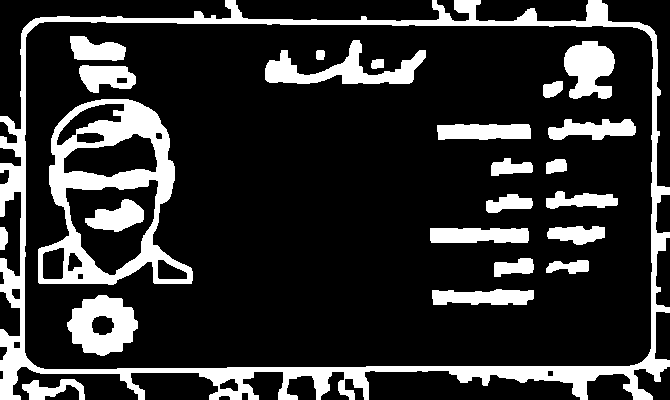

In [12]:
cv2_imshow(imgThreshold)

In [13]:
## FIND ALL COUNTOURS
imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 10) # DRAW ALL DETECTED CONTOURS

array([[[146, 184, 214],
        [139, 177, 207],
        [133, 172, 201],
        ...,
        [131, 170, 200],
        [129, 167, 197],
        [126, 164, 194]],

       [[137, 176, 205],
        [141, 178, 209],
        [140, 177, 208],
        ...,
        [133, 171, 201],
        [130, 167, 198],
        [124, 162, 192]],

       [[117, 155, 185],
        [128, 166, 196],
        [133, 171, 201],
        ...,
        [135, 173, 204],
        [132, 170, 200],
        [124, 162, 192]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [124, 163, 196],
        [111, 150, 182],
        [103, 142, 174]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [107, 146, 178],
        [115, 154, 186],
        [106, 145, 177]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [108, 147, 179],
        [104, 143, 175],
        [ 99, 138, 169]]

In [14]:
# FIND THE BIGGEST COUNTOUR
biggest, maxArea = utlis.biggestContour(contours) # FIND THE BIGGEST CONTOUR
if biggest.size != 0:
    print("Biggest size is found...")
    biggest=utlis.reorder(biggest)
    cv2.drawContours(imgBigContour, biggest, -1, (0, 255, 0), 20) # DRAW THE BIGGEST CONTOUR
    imgBigContour = utlis.drawRectangle(imgBigContour,biggest,2)
    pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
    pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))

    #REMOVE 20 PIXELS FORM EACH SIDE
    imgWarpColored=imgWarpColored[20:imgWarpColored.shape[0] - 20, 20:imgWarpColored.shape[1] - 20]
    imgWarpColored = cv2.resize(imgWarpColored,(widthImg,heightImg))

    # APPLY ADAPTIVE THRESHOLD
    imgWarpGray = cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY)
    imgAdaptiveThre= cv2.adaptiveThreshold(imgWarpGray, 255, 1, 1, 7, 2)
    imgAdaptiveThre = cv2.bitwise_not(imgAdaptiveThre)
    imgAdaptiveThre=cv2.medianBlur(imgAdaptiveThre,3)

    # Image Array for Display
    imageArray = ([img,imgGray,imgThreshold,imgContours],
                  [imgBigContour,imgWarpColored, imgWarpGray,imgAdaptiveThre])

else:
    print("Biggest size is finding...")
    imageArray = ([img,imgGray,imgThreshold,imgContours],
                  [imgBlank, imgBlank, imgBlank, imgBlank])


Biggest size is found...


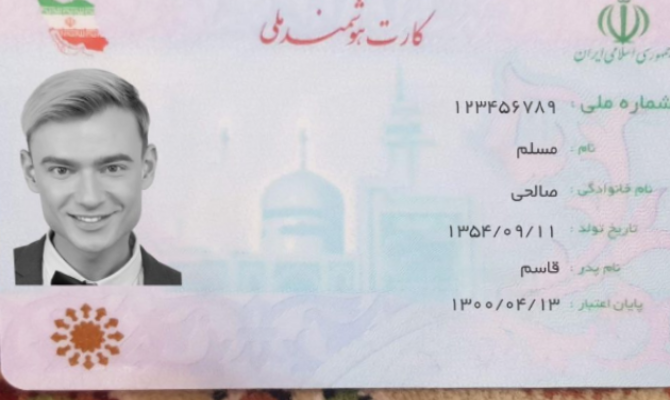

In [15]:
# LABELS FOR DISPLAY
lables = [["Original","Gray","Threshold","Contours"],
          ["Biggest Contour","Warp Prespective","Warp Gray","Adaptive Threshold"]]

cv2_imshow(imageArray[1][1])

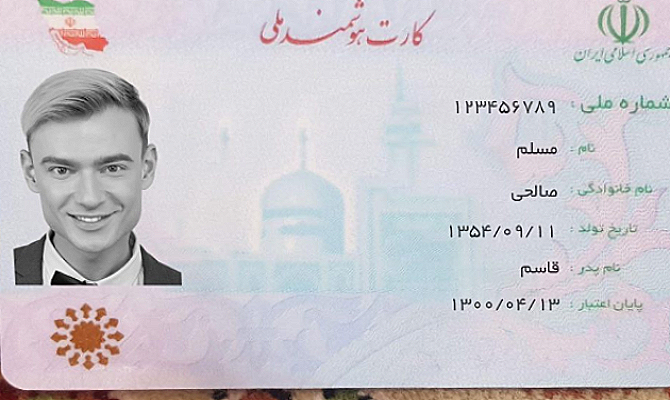

In [16]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
imgsharp = cv2.filter2D(src=imageArray[1][1], ddepth=-1, kernel=kernel)
cv2_imshow(imgsharp)

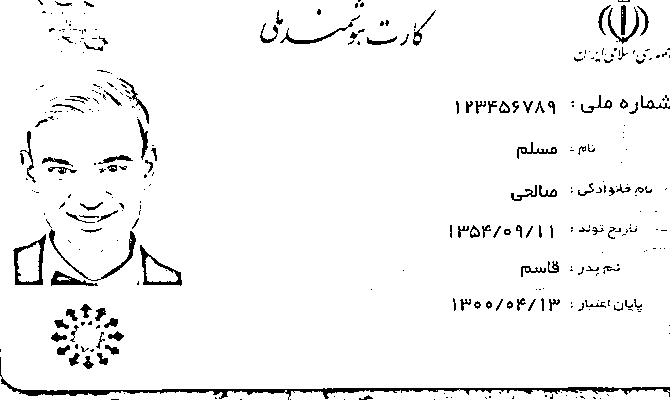

In [17]:
gray = cv2.cvtColor(imgsharp, cv2.COLOR_BGR2GRAY)

th3 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, 30)
cv2_imshow(th3)

<ipython-input-18-3a0871f7e8a9>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  imgWSO = np.array(backtorgb).astype(np.bool)


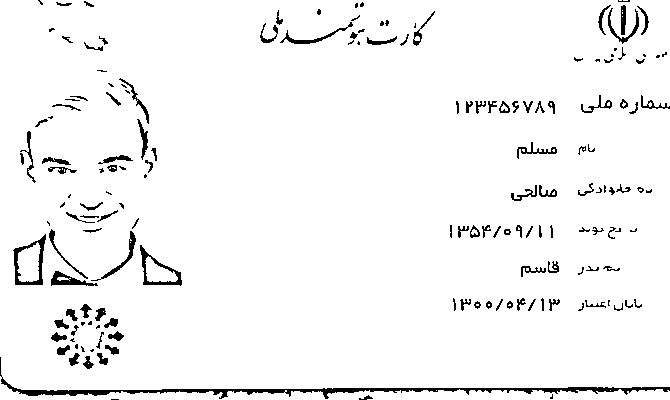

In [18]:
backtorgb = cv2.cvtColor(th3,cv2.COLOR_GRAY2RGB)

imgWSO = np.array(backtorgb).astype(np.bool) # imgWSO = Image Without Small Objects
imgWSO = morphology.remove_small_holes(imgWSO, 20).astype(np.uint8)
# imgWSO = morphology.remove_small_objects(imgWSO, min_size=10, connectivity=10).astype(np.uint8)

imgWSO[imgWSO==1]=255
imgWSO = cv2.cvtColor(imgWSO, cv2.COLOR_RGB2GRAY)
cv2_imshow(imgWSO)

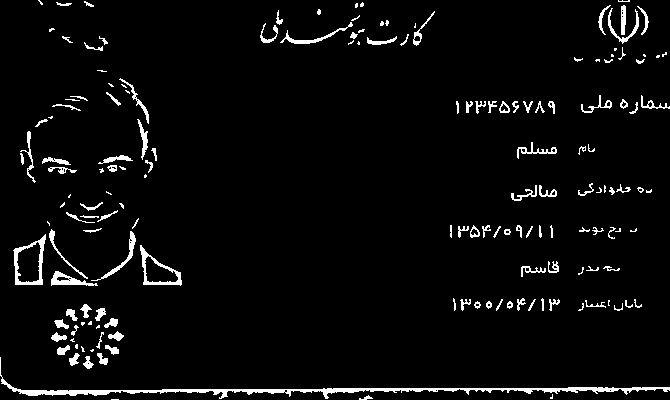

In [19]:
# Back image to normal
for i in range(imgWSO.shape[0]):
  for j in range(imgWSO.shape[1]):
    if imgWSO[i,j] == 255:
      imgWSO[i,j] = 0
    else:
      imgWSO[i,j] = 255
imgbinary = imgWSO.copy()
cv2_imshow(imgbinary)

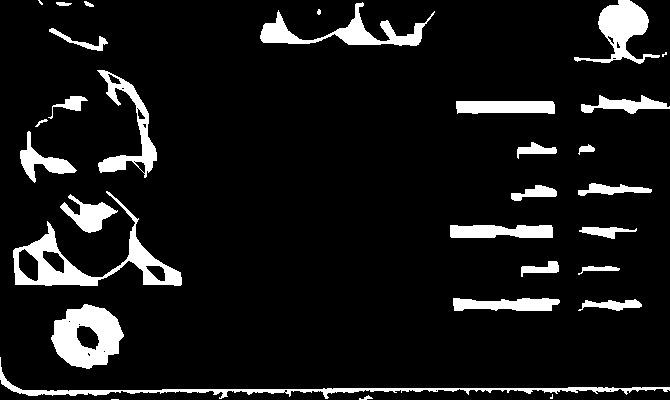

In [20]:
imgheight, imgwidth = imgbinary.shape[0], imgbinary.shape[1]

imgconnected = imgbinary.copy()

connectivity = 15

for i in range(imgheight-connectivity):
  for j in range(imgwidth-connectivity):

    if imgbinary[i,j] == 255:

      for k in range(connectivity):
        for l in range(connectivity):
          if imgbinary[i+k, j+l] == 255:
            imgconnected = cv2.line(imgconnected, (j,i), (j+l, i+k), (255, 255, 255))

cv2_imshow(imgconnected)

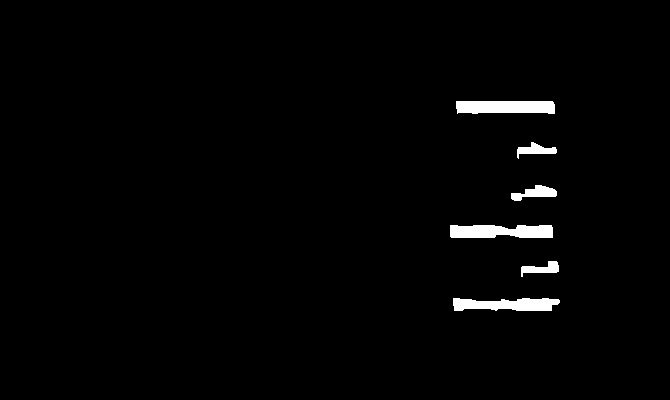

In [21]:
imglabeled = label(imgconnected)

listlabels = list(set(imglabeled[:, 530]))

# Create a list contain labels which should'nt be in the image
listerror = []
for i in range(45):
  listset = list(set(imglabeled[i,:]))
  for x in listset:
    listerror.append(x)
for i in range(20):
  listset = list(set(imglabeled[imglabeled.shape[0]-20+i,:]))
  for x in listset:
    listerror.append(x)
listerror = list(set(listerror))

# Delete error labels
for i in range(imgheight):
  for j in range(imgwidth):
    if (imglabeled[i,j] in listerror):
      imgconnected[i,j] = 0
    else:
      pass

# Keep wright labels
for i in range(imgheight):
  for j in range(imgwidth):
    if (imglabeled[i,j] in listlabels):
      pass
    else:
      imgconnected[i,j] = 0

imgconnected[imgconnected!=0]=255
cv2_imshow(imgconnected)

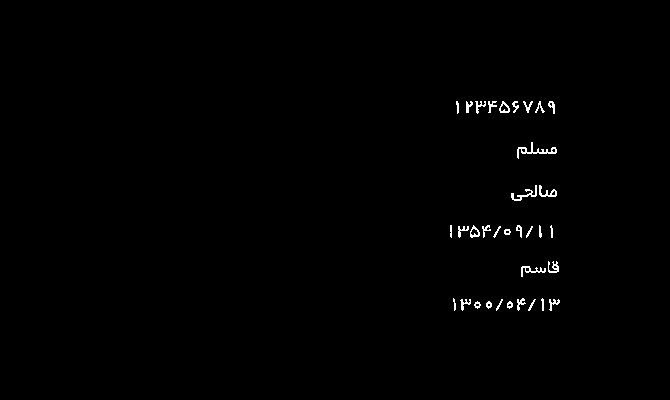

In [22]:
imagefull = np.multiply(imgconnected, imgbinary)

for i in range(imgheight):
  for j in range(imgwidth):
    if (imagefull[i,j] == 0):
      pass
    else:
      imagefull[i,j] = 255

cv2_imshow(imagefull)

In [23]:
cv2.imwrite("imagefull.jpg", imagefull)

True

## Extract each part separately:

In [24]:
imgarea = np.copy(imgconnected)
imglabeled = label(imgarea)
column = imglabeled[:, 530]
labels = []
num = 0
for i in range(len(column)):
  if column[i]!=0 and num==0:
    labels.append(column[i])
    num = num+1
  elif column[i]!=0:
    if column[i] in labels:
      pass
    else:
      labels.append(column[i])

print(labels)

[1, 2, 3, 4, 5, 6]


In [25]:
idnumber = np.copy(imglabeled)
name = np.copy(imglabeled)
familyname = np.copy(imglabeled)
birthdate = np.copy(imglabeled)
fathername = np.copy(imglabeled)
expirydate = np.copy(imglabeled)
#-------------------------------------------------------------------------------
idnumber[idnumber==labels[0]]=255
idnumber[idnumber!=255]=0

name[name==labels[1]]=255
name[name!=255]=0

familyname[familyname==labels[2]]=255
familyname[familyname!=255]=0

birthdate[birthdate==labels[3]]=255
birthdate[birthdate!=255]=0

fathername[fathername==labels[4]]=255
fathername[fathername!=255]=0

expirydate[expirydate==labels[5]]=255
expirydate[expirydate!=255]=0
#-------------------------------------------------------------------------------
idnumber = np.multiply(idnumber, imgbinary)
idnumber[idnumber!=0]=255
idnumber = idnumber.astype(np.uint8)

name = np.multiply(name, imgbinary)
name[name!=0]=255
name = name.astype(np.uint8)

familyname = np.multiply(familyname, imgbinary)
familyname[familyname!=0]=255
familyname = familyname.astype(np.uint8)

birthdate = np.multiply(birthdate, imgbinary)
birthdate[birthdate!=0]=255
birthdate = birthdate.astype(np.uint8)

fathername = np.multiply(fathername, imgbinary)
fathername[fathername!=0]=255
fathername = fathername.astype(np.uint8)

expirydate = np.multiply(expirydate, imgbinary)
expirydate[expirydate!=0]=255
expirydate = expirydate.astype(np.uint8)


In [26]:
cv2.imwrite("name.jpg", name)
cv2.imwrite("familyname.jpg", familyname)
cv2.imwrite("fathername.jpg", fathername)

True

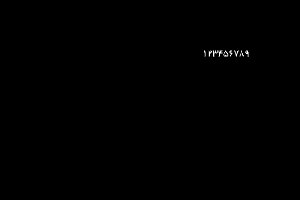

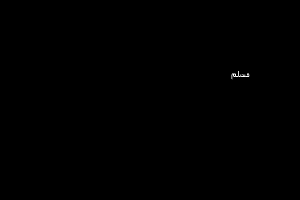

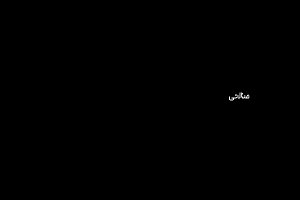

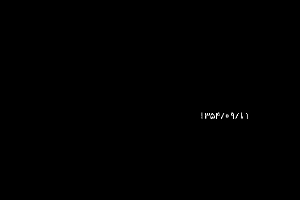

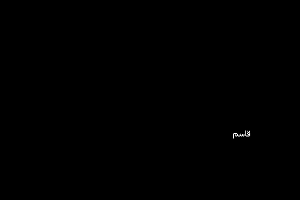

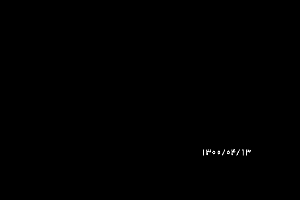

In [27]:
cv2_imshow(cv2.resize(idnumber, (300, 200)))
cv2_imshow(cv2.resize(name, (300, 200)))
cv2_imshow(cv2.resize(familyname, (300, 200)))
cv2_imshow(cv2.resize(birthdate, (300, 200)))
cv2_imshow(cv2.resize(fathername, (300, 200)))
cv2_imshow(cv2.resize(expirydate, (300, 200)))

## Preprocessing numbers:

In [28]:
def ChangeAroundAPoint(myimg, x, y, targetvalue): # Try Except is for not getting error in image's borders
  # try:
  #   myimg[x+1,y-1] = targetvalue
  # except:
  #   pass
  # try:
  #   myimg[x+1,y] = targetvalue
  # except:
  #   pass
  # try:
  #   myimg[x+1,y+1] = targetvalue
  # except:
  #   pass
  # try:
  #   myimg[x,y-1] = targetvalue
  # except:
  #   pass
  # try:
  #   myimg[x,y+1] = targetvalue
  # except:
  #   pass
  try:
    myimg[x-1,y-1] = targetvalue
  except:
    pass
  try:
    myimg[x-1,y] = targetvalue
  except:
    pass
  try:
    myimg[x-1,y+1] = targetvalue
  except:
    pass

  return(myimg)

def ClosingNumbersTogether(myimg):
  
  LabeledCleanImg = label(myimg)
  labels = []
  for column in range(myimg.shape[1]):
    columnlabels = list(set(LabeledCleanImg[:,column]))
    for i in range(len(columnlabels)):
      if columnlabels[i] != 0:
        if columnlabels[i] in labels:
          pass
        else:
          labels.append(columnlabels[i])

  # ----------------------------------------------------------------------------
  ListMinMaxLabels = []
  for l in range(len(labels)):
    Is, Js = [], []
    for i in range(LabeledCleanImg.shape[0]):
      for j in range(LabeledCleanImg.shape[1]):
        if LabeledCleanImg[i,j] == labels[l]:
          Js.append(j)
    ListMinMaxLabels.append([min(Js), max(Js)])

  # ---------------------------------------------------------------------------
  ShiftPixel = 0
  for minmax in range(len(ListMinMaxLabels)-1):
    diff =  abs(ListMinMaxLabels[minmax][1] - ListMinMaxLabels[minmax+1][0])
    if diff > 5:
      ShiftPixel = ShiftPixel + abs(diff-5)
      for i in range(LabeledCleanImg.shape[0]):
        for j in range(LabeledCleanImg.shape[1]):
          if LabeledCleanImg[i,j] == labels[minmax+1]:
            LabeledCleanImg[i,j] = 0
            LabeledCleanImg[i,j-ShiftPixel] = 255
    elif ShiftPixel != 0:
      for i in range(LabeledCleanImg.shape[0]):
        for j in range(LabeledCleanImg.shape[1]):
          if LabeledCleanImg[i,j] == labels[minmax+1]:
            LabeledCleanImg[i,j] = 0
            LabeledCleanImg[i,j-ShiftPixel] = 255
  LabeledCleanImg[LabeledCleanImg>=1]=255

  return LabeledCleanImg

def SkeletoneGrayImage(myimg):
  for i in range(myimg.shape[0]):
    for j in range(myimg.shape[1]):
      if myimg[i,j] > 1:
        myimg[i,j] = 1
      else:
        myimg[i,j] = 0

  skeleton = skeletonize(myimg)
  myskl = []
  for i in range(myimg.shape[0]):
    row = []
    for j in range(myimg.shape[1]):
      if skeleton[i,j] == False:
        row.append(0)
      else:
        row.append(255)
    myskl.append(row)
  myskl = np.array(myskl)
  return myskl

def RemoveSmallDisconnectivities(myimg):
  for i in range(myimg.shape[0]):
    for j in range(myimg.shape[1]):
      if myimg[i,j] == 255:
        try:
          if myimg[i-2,j-1] == 255 or myimg[i-1,j-2] == 255:
            myimg[i-1,j-1] = 255
        except:
          pass
        try:
          if myimg[i-2,j] == 255:
            myimg[i-1,j] = 255
        except:
          pass
        try:
          if myimg[i-2,j+1] == 255 or myimg[i-1,j+2] == 255:
            myimg[i-1,j+1] = 255
        except:
          pass

  return myimg

def UpdateListWhithOnes(myskl, myIndexNonZeroSlashList, mylist, mylabels):
  # Create labeled skl
  skl01 = np.zeros(myskl.shape)
  for i in range(myskl.shape[0]):
    for j in range(myskl.shape[1]):
      if myskl[i,j] != 0:
        skl01[i,j] = 1
      else:
        skl01[i,j] = 0
  labeledskl = skl01 * labeledimg

  # Extract ones
  for index in myIndexNonZeroSlashList:
    IJs = []
    for i in range(myskl.shape[0]):
      for j in range(myskl.shape[1]):
        if labeledskl[i,j] == labels[index]:
          IJs.append([i,j])

    lenijs = 1
    for z in range(len(IJs)-1):
      if IJs[z+1] in [[IJs[z][0]+1,IJs[z][1]-1], [IJs[z][0]+1,IJs[z][1]], [IJs[z][0]+1,IJs[z][1]+1]]:
        lenijs = lenijs+1
      
    if len(IJs) == lenijs:
      mylist[index] = 1

  return mylist

### IDNumber:

In [29]:
changingimg = idnumber.copy()

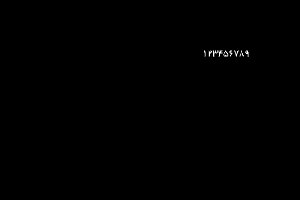

In [30]:
cv2_imshow(cv2.resize(changingimg, (300, 200)))

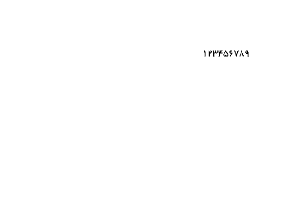

In [31]:
# Reversing image for filling small holes (filling zeros)
for i in range(changingimg.shape[0]):
  for j in range(changingimg.shape[1]):
    if changingimg[i,j] == 255:
      changingimg[i,j] = 0
    else:
      changingimg[i,j] = 255

cv2_imshow(cv2.resize(changingimg, (300, 200)))

<ipython-input-32-93cf0c18d5d3>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  changingimg = np.array(changingimg).astype(np.bool)


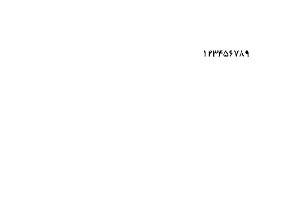

In [32]:
# Remove small objects (removing holes in zeros)
changingimg = np.array(changingimg).astype(np.bool)
changingimg = morphology.remove_small_objects(changingimg, min_size=20, connectivity=50).astype(np.uint8)

changingimg[changingimg==1]=255
cv2_imshow(cv2.resize(changingimg, (300, 200)))

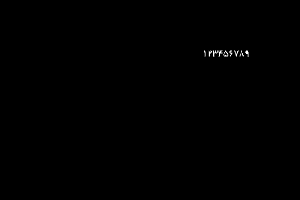

In [33]:
# Back image to normal
for i in range(changingimg.shape[0]):
  for j in range(changingimg.shape[1]):
    if changingimg[i,j] == 255:
      changingimg[i,j] = 0
    else:
      changingimg[i,j] = 255

cv2_imshow(cv2.resize(changingimg, (300, 200)))

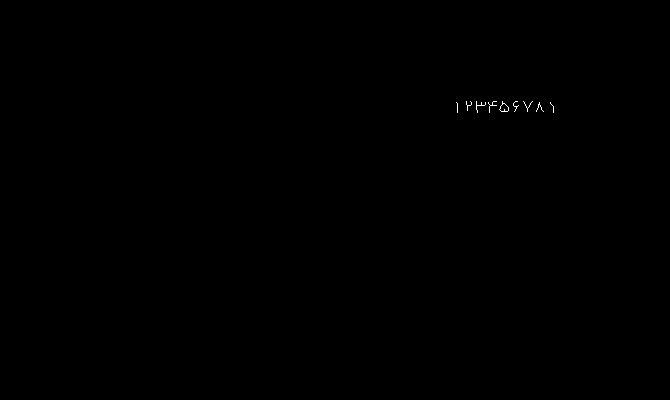

In [34]:
# Get the skeletone of our image
skl = SkeletoneGrayImage(changingimg)
cv2_imshow(skl)

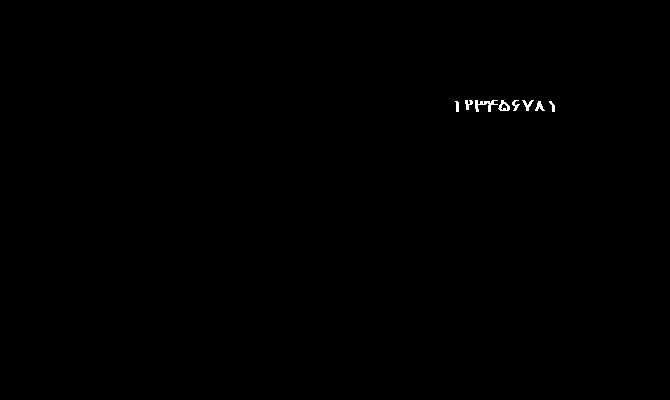

In [35]:
# Make each line thicker for labeling each number separately
newskl = np.zeros((skl.shape[0], skl.shape[1]))

for i in range(skl.shape[0]):
  for j in range(skl.shape[1]):
    if skl[i,j] == 255:
      myimg = ChangeAroundAPoint(newskl, i, j, 255)
      newskl = myimg + newskl

cv2_imshow(newskl)

In [36]:
# Make sure that our image is a binary image
for i in range(newskl.shape[0]):
  for j in range(newskl.shape[1]):
    if newskl[i,j] > 1:
      newskl[i,j] = 255
    else:
      newskl[i,j] = 0

In [37]:
# Labeling image
labeledimg = label(newskl)

# Get labels of objects by order (left to right)
labels = []
for column in range(labeledimg.shape[1]):
  
  columnlabels = list(set(labeledimg[:,column]))
  for i in range(len(columnlabels)):
    if columnlabels[i] != 0:
      if columnlabels[i] in labels:
        pass
      else:
        labels.append(columnlabels[i])

if len(labels) != 10:
  print("Count of objects must be 10...")

print(labels)

Count of objects must be 10...
[6, 1, 2, 3, 4, 5, 7, 8]


In [38]:
# Get the pixel number of each object
countlist = []

for l in range(len(labels)):
  countlabel = 0
  for i in range(labeledimg.shape[0]):
    for j in range(labeledimg.shape[1]):
      if labeledimg[i,j] == labels[l]:
        countlabel = countlabel+1

  countlist.append(countlabel)
print(countlist)

[33, 45, 116, 68, 41, 53, 50, 33]


In [39]:
# Extract objects which there pixel number is less than 15 (recognizing zeros)
zerolistindex = []

for i in range(len(countlist)):
  if countlist[i] < 15:
    zerolistindex.append(i)

print(zerolistindex)

[]


In [40]:
# Create a list of ID numbers
IDList = np.zeros(len(labels))
# BDList[4] = 11 # 11 means slash (It's a rule just for myself)
# BDList[7] = 11
for z in zerolistindex:
  IDList[z] = 10 # 10 means zero (It's a rule just for myself)

In [41]:
# Extract index of non zero and slash elements in BDList for filling it
IndexNonZeroSlashList = []
for i in range(len(labels)):
  if IDList[i] == 0:
    IndexNonZeroSlashList.append(i)

print(IndexNonZeroSlashList)

[0, 1, 2, 3, 4, 5, 6, 7]


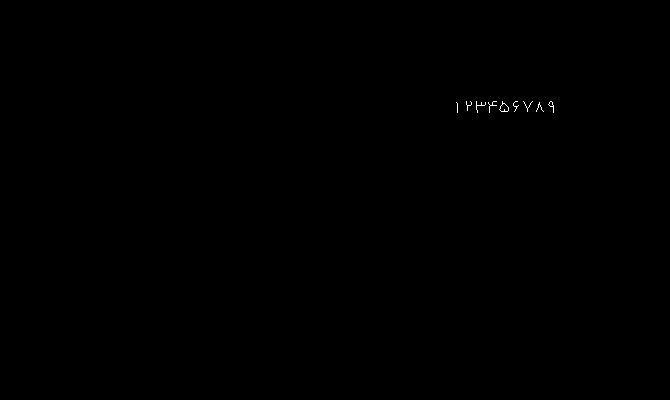

In [42]:
# Get the skeletone of our image
rawskl = SkeletoneGrayImage(idnumber)
cv2_imshow(rawskl)

In [43]:
IDList = UpdateListWhithOnes(rawskl, IndexNonZeroSlashList, IDList, labels)
print(IDList)

[1. 0. 0. 0. 0. 0. 0. 0.]


In [44]:
# Extract index of non zero, slash and one elements in BDList for filling it
IndexNonZeroSlashOneList = []
for i in range(len(labels)):
  if IDList[i] == 0:
    IndexNonZeroSlashOneList.append(i)

print(IndexNonZeroSlashOneList)

[1, 2, 3, 4, 5, 6, 7]


In [45]:
# labeling our raw image
labeledimg = label(idnumber)

labels = []
for column in range(labeledimg.shape[1]):
  columnlabels = list(set(labeledimg[:,column]))
  for i in range(len(columnlabels)):
    if columnlabels[i] != 0:
      if columnlabels[i] in labels:
        pass
      else:
        labels.append(columnlabels[i])

if len(labels) != 10:
  print("Count of objects must be 10...")

print(labels)

Count of objects must be 10...
[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [46]:
# Extract object's labels which are'nt zero or slash or one
LabelsWithoutZeroSlashOne = []
for index in IndexNonZeroSlashOneList:
  LabelsWithoutZeroSlashOne.append(labels[index])
print(LabelsWithoutZeroSlashOne)

[2, 3, 4, 5, 6, 7, 8]


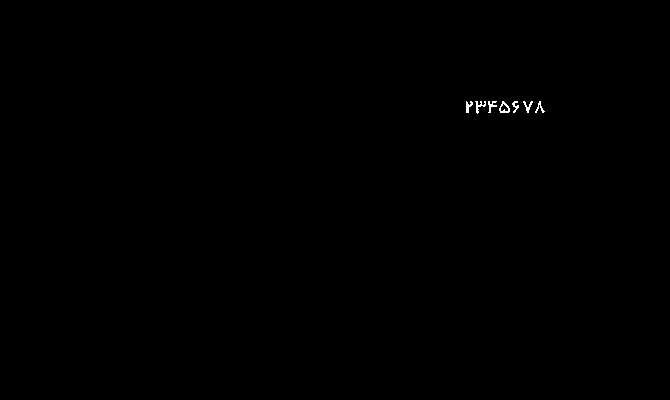

In [47]:
# Build an image without zero, slash and one
for i in range(labeledimg.shape[0]):
  for j in range(labeledimg.shape[1]):
    if labeledimg[i,j] in LabelsWithoutZeroSlashOne:
      labeledimg[i,j] = 255
    else:
      labeledimg[i,j] = 0
cv2_imshow(labeledimg)

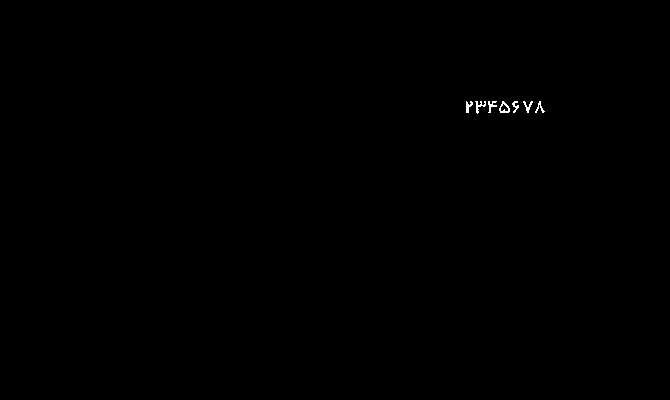

In [48]:
# Closing numbers to each other to create a single number for a better OCRing
newimg = ClosingNumbersTogether(labeledimg)
cv2_imshow(newimg)

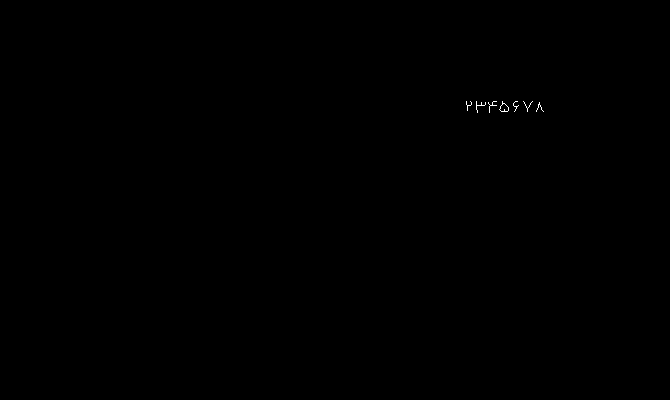

In [49]:
# Get the skeletone of our image
newimg = SkeletoneGrayImage(newimg)
cv2_imshow(newimg)

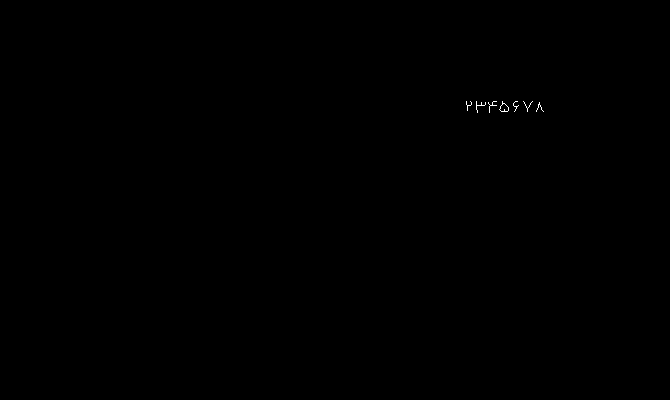

In [50]:
# Closing numbers to each other to create a single number for a better OCRing
newimg = ClosingNumbersTogether(newimg)
cv2_imshow(newimg)

In [51]:
Is, Js = [], []
for i in range(newimg.shape[0]):
  for j in range(newimg.shape[1]):
    if newimg[i,j] != 0:
      Is.append(i)
      Js.append(j)

finalimg = newimg[min(Is)-10:max(Is)+10, min(Js)-10:max(Js)+10]
cv2_imshow(finalimg)

In [52]:
for i in range(finalimg.shape[0]):
  for j in range(finalimg.shape[1]):
    if finalimg[i,j] != 0:
      finalimg[i,j-1] = 255

cv2_imshow(finalimg)

In [53]:
cv2.imwrite("idnumber.jpg", finalimg)

True

### BirthDate:

In [54]:
changingimg = birthdate.copy()

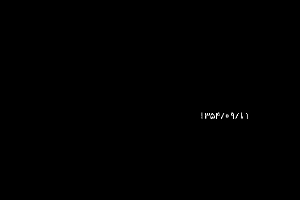

In [55]:
cv2_imshow(cv2.resize(changingimg, (300, 200)))

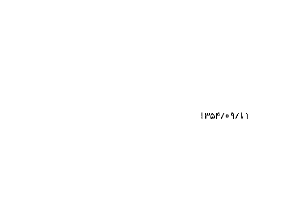

In [56]:
# Reversing image for filling small holes (filling zeros)
for i in range(changingimg.shape[0]):
  for j in range(changingimg.shape[1]):
    if changingimg[i,j] == 255:
      changingimg[i,j] = 0
    else:
      changingimg[i,j] = 255

cv2_imshow(cv2.resize(changingimg, (300, 200)))

<ipython-input-57-93cf0c18d5d3>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  changingimg = np.array(changingimg).astype(np.bool)


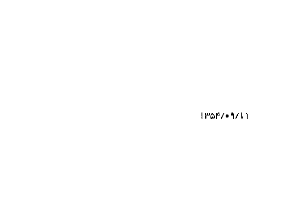

In [57]:
# Remove small objects (removing holes in zeros)
changingimg = np.array(changingimg).astype(np.bool)
changingimg = morphology.remove_small_objects(changingimg, min_size=20, connectivity=50).astype(np.uint8)

changingimg[changingimg==1]=255
cv2_imshow(cv2.resize(changingimg, (300, 200)))

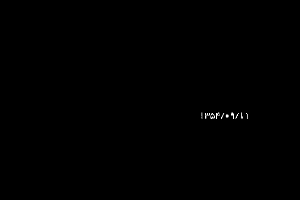

In [58]:
# Back image to normal
for i in range(changingimg.shape[0]):
  for j in range(changingimg.shape[1]):
    if changingimg[i,j] == 255:
      changingimg[i,j] = 0
    else:
      changingimg[i,j] = 255

cv2_imshow(cv2.resize(changingimg, (300, 200)))

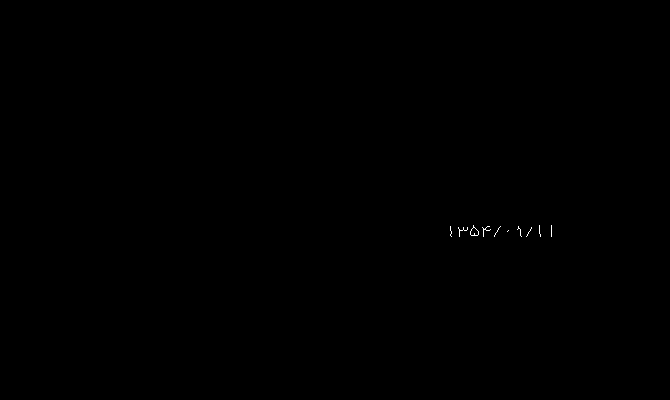

In [59]:
# Get the skeletone of our image
skl = SkeletoneGrayImage(changingimg)
cv2_imshow(skl)

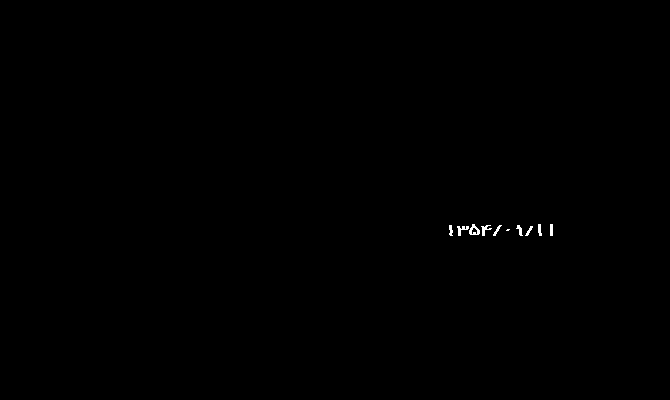

In [60]:
# Make each line thicker for labeling each number separately
newskl = np.zeros((skl.shape[0], skl.shape[1]))

for i in range(skl.shape[0]):
  for j in range(skl.shape[1]):
    if skl[i,j] == 255:
      myimg = ChangeAroundAPoint(newskl, i, j, 255)
      newskl = myimg + newskl

cv2_imshow(newskl)

In [61]:
# Make sure that our image is a binary image
for i in range(newskl.shape[0]):
  for j in range(newskl.shape[1]):
    if newskl[i,j] > 1:
      newskl[i,j] = 255
    else:
      newskl[i,j] = 0

In [62]:
# Labeling image
labeledimg = label(newskl)

# Get labels of objects by order (left to right)
labels = []
for column in range(labeledimg.shape[1]):
  
  columnlabels = list(set(labeledimg[:,column]))
  # print(columnlabels)
  for i in range(len(columnlabels)):
    if columnlabels[i] != 0:
      if columnlabels[i] in labels:
        pass
      else:
        labels.append(columnlabels[i])

if len(labels) != 10:
  print("Count of objects must be 10...")

print(labels)

[4, 8, 1, 5, 6, 10, 7, 9, 2, 3]


In [63]:
# Get the pixel number of each object
countlist = []

for l in range(len(labels)):
  countlabel = 0
  for i in range(labeledimg.shape[0]):
    for j in range(labeledimg.shape[1]):
      if labeledimg[i,j] == labels[l]:
        countlabel = countlabel+1

  countlist.append(countlabel)
print(countlist)

[33, 55, 67, 51, 33, 6, 37, 30, 36, 36]


In [64]:
# Extract objects which there pixel number is less than 20 (recognizing zeros)
zerolistindex = []

for i in range(len(countlist)):
  if countlist[i] < 20:
    zerolistindex.append(i)

print(zerolistindex)

[5]


In [65]:
# Create a list of Birth Date numbers
BDList = np.zeros(len(labels))
BDList[4] = 11 # 11 means slash (It's a rule just for myself)
BDList[7] = 11
for z in zerolistindex:
  BDList[z] = 10 # 10 means zero (It's a rule just for myself)

In [66]:
# Extract index of non zero and slash elements in BDList for filling it
IndexNonZeroSlashList = []
for i in range(len(labels)):
  if BDList[i] == 0:
    IndexNonZeroSlashList.append(i)

print(IndexNonZeroSlashList)

[0, 1, 2, 3, 6, 8, 9]


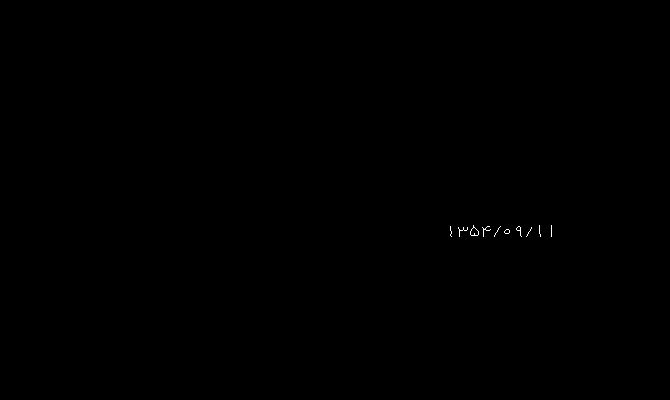

In [67]:
# Get the skeletone of our image
rawskl = SkeletoneGrayImage(birthdate)
cv2_imshow(rawskl)

In [68]:
BDList = UpdateListWhithOnes(rawskl, IndexNonZeroSlashList, BDList, labels)
print(BDList)

[ 1.  0.  0.  0. 11. 10.  0. 11.  1.  1.]


In [69]:
# Extract index of non zero, slash and one elements in BDList for filling it
IndexNonZeroSlashOneList = []
for i in range(len(labels)):
  if BDList[i] == 0:
    IndexNonZeroSlashOneList.append(i)

print(IndexNonZeroSlashOneList)

[1, 2, 3, 6]


In [70]:
# labeling our raw image
labeledimg = label(birthdate)

labels = []
for column in range(labeledimg.shape[1]):
  columnlabels = list(set(labeledimg[:,column]))
  for i in range(len(columnlabels)):
    if columnlabels[i] != 0:
      if columnlabels[i] in labels:
        pass
      else:
        labels.append(columnlabels[i])

if len(labels) != 10:
  print("Count of objects must be 10...")

print(labels)

[1, 7, 2, 3, 8, 10, 4, 9, 5, 6]


In [71]:
# Extract object's labels which are'nt zero or slash or one
LabelsWithoutZeroSlashOne = []
for index in IndexNonZeroSlashOneList:
  LabelsWithoutZeroSlashOne.append(labels[index])
print(LabelsWithoutZeroSlashOne)

[7, 2, 3, 4]


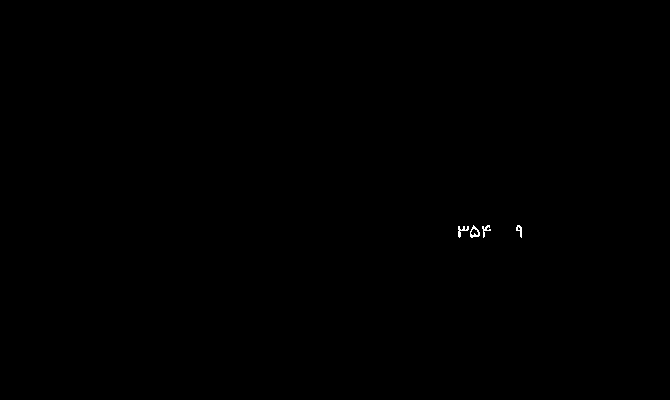

In [72]:
# Build an image without zero, slash and one
for i in range(labeledimg.shape[0]):
  for j in range(labeledimg.shape[1]):
    if labeledimg[i,j] in LabelsWithoutZeroSlashOne:
      labeledimg[i,j] = 255
    else:
      labeledimg[i,j] = 0
cv2_imshow(labeledimg)

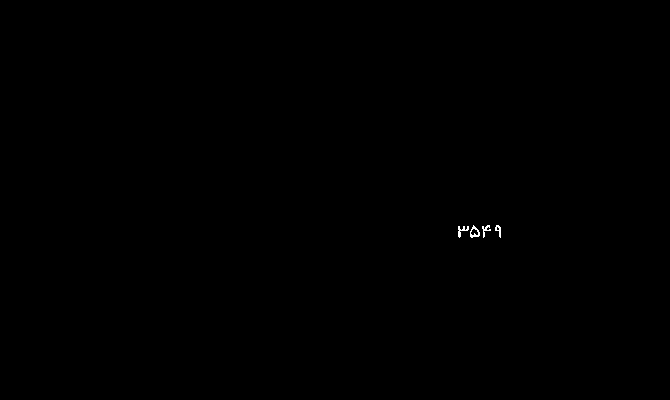

In [73]:
# Closing numbers to each other to create a single number for a better OCRing
newimg = ClosingNumbersTogether(labeledimg)
cv2_imshow(newimg)

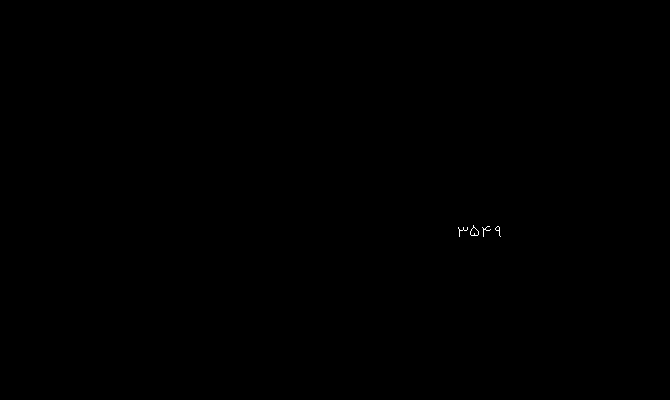

In [74]:
# Get the skeletone of our image
newimg = SkeletoneGrayImage(newimg)
cv2_imshow(newimg)

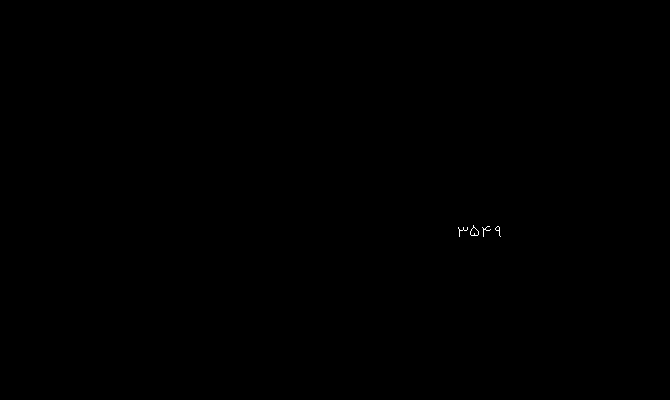

In [75]:
# Closing numbers to each other to create a single number for a better OCRing
newimg = ClosingNumbersTogether(newimg)
cv2_imshow(newimg)

In [76]:
Is, Js = [], []
for i in range(newimg.shape[0]):
  for j in range(newimg.shape[1]):
    if newimg[i,j] != 0:
      Is.append(i)
      Js.append(j)

finalimg = newimg[min(Is)-10:max(Is)+10, min(Js)-10:max(Js)+10]
cv2_imshow(finalimg)

In [77]:
for i in range(finalimg.shape[0]):
  for j in range(finalimg.shape[1]):
    if finalimg[i,j] != 0:
      finalimg[i,j-1] = 255

cv2_imshow(finalimg)

In [78]:
cv2.imwrite("birthdate.jpg", finalimg)

True

### ExpiryDate:

In [79]:
changingimg = expirydate.copy()

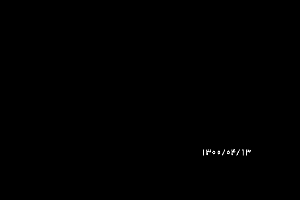

In [80]:
cv2_imshow(cv2.resize(changingimg, (300, 200)))
# cv2_imshow(changingimg)

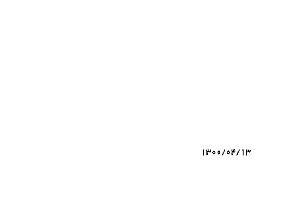

In [81]:
# Reversing image for filling small holes (filling zeros)
for i in range(changingimg.shape[0]):
  for j in range(changingimg.shape[1]):
    if changingimg[i,j] == 255:
      changingimg[i,j] = 0
    else:
      changingimg[i,j] = 255

cv2_imshow(cv2.resize(changingimg, (300, 200)))

<ipython-input-82-93cf0c18d5d3>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  changingimg = np.array(changingimg).astype(np.bool)


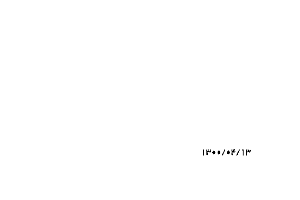

In [82]:
# Remove small objects (removing holes in zeros)
changingimg = np.array(changingimg).astype(np.bool)
changingimg = morphology.remove_small_objects(changingimg, min_size=20, connectivity=50).astype(np.uint8)

changingimg[changingimg==1]=255
cv2_imshow(cv2.resize(changingimg, (300, 200)))

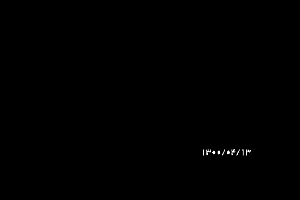

In [83]:
# Back image to normal
for i in range(changingimg.shape[0]):
  for j in range(changingimg.shape[1]):
    if changingimg[i,j] == 255:
      changingimg[i,j] = 0
    else:
      changingimg[i,j] = 255

cv2_imshow(cv2.resize(changingimg, (300, 200)))

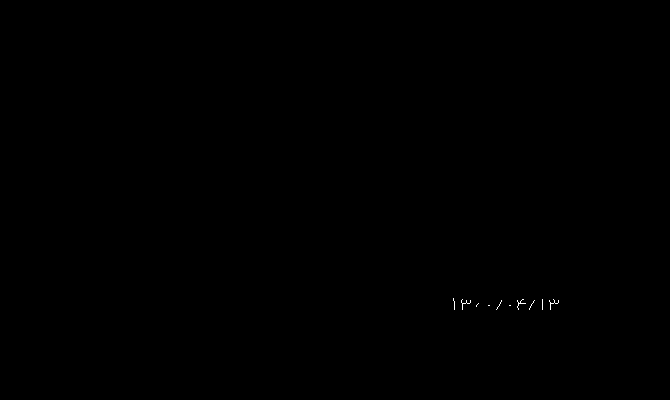

In [84]:
# Get the skeletone of our image
skl = SkeletoneGrayImage(changingimg)
cv2_imshow(skl)

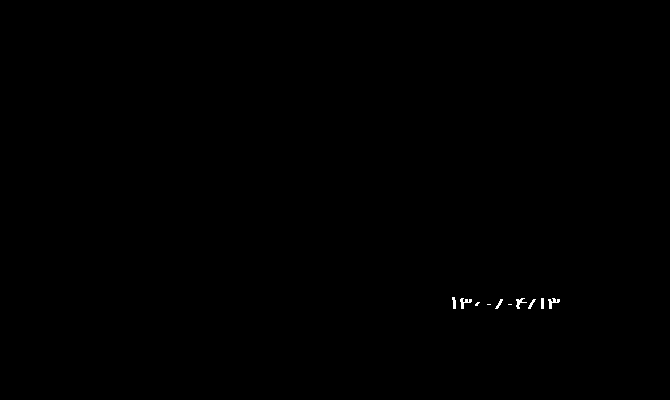

In [85]:
# Make each line thicker for labeling each number separately
newskl = np.zeros((skl.shape[0], skl.shape[1]))

for i in range(skl.shape[0]):
  for j in range(skl.shape[1]):
    if skl[i,j] == 255:
      myimg = ChangeAroundAPoint(newskl, i, j, 255)
      newskl = myimg + newskl

cv2_imshow(newskl)

In [86]:
# Make sure that our image is a binary image
for i in range(newskl.shape[0]):
  for j in range(newskl.shape[1]):
    if newskl[i,j] > 1:
      newskl[i,j] = 255
    else:
      newskl[i,j] = 0

In [87]:
# Labeling image
labeledimg = label(newskl)

# Get labels of objects by order (left to right)
labels = []
for column in range(labeledimg.shape[1]):
  
  columnlabels = list(set(labeledimg[:,column]))
  for i in range(len(columnlabels)):
    if columnlabels[i] != 0:
      if columnlabels[i] in labels:
        pass
      else:
        labels.append(columnlabels[i])

if len(labels) != 10:
  print("Count of objects must be 10...")

print(labels)

[1, 2, 8, 9, 6, 10, 3, 7, 4, 5]


In [88]:
# Get the pixel number of each object
countlist = []

for l in range(len(labels)):
  countlabel = 0
  for i in range(labeledimg.shape[0]):
    for j in range(labeledimg.shape[1]):
      if labeledimg[i,j] == labels[l]:
        countlabel = countlabel+1

  countlist.append(countlabel)
print(countlist)

[36, 58, 12, 4, 30, 4, 49, 30, 33, 58]


In [89]:
# Extract objects which there pixel number is less than 15 (recognizing zeros)
zerolistindex = []

for i in range(len(countlist)):
  if countlist[i] < 20:
    zerolistindex.append(i)

print(zerolistindex)

[2, 3, 5]


In [90]:
# Create a list of Expiry Date numbers
EDList = np.zeros(len(labels))
EDList[4] = 11 # 11 means slash (It's a rule just for myself)
EDList[7] = 11
for z in zerolistindex:
  EDList[z] = 10 # 10 means zero (It's a rule just for myself)

In [91]:
# Extract index of non zero and slash elements in BDList for filling it
IndexNonZeroSlashList = []
for i in range(len(labels)):
  if EDList[i] == 0:
    IndexNonZeroSlashList.append(i)

print(IndexNonZeroSlashList)

[0, 1, 6, 8, 9]


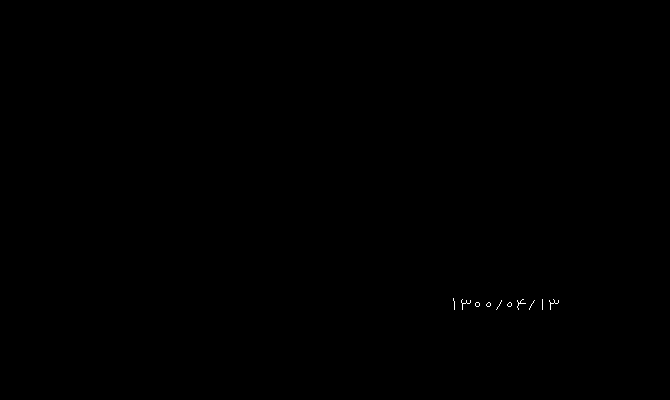

In [92]:
# Get the skeletone of our image
rawskl = SkeletoneGrayImage(expirydate)
cv2_imshow(rawskl)

In [93]:
EDList = UpdateListWhithOnes(rawskl, IndexNonZeroSlashList, EDList, labels)
print(EDList)

[ 1.  0. 10. 10. 11. 10.  0. 11.  1.  0.]


In [94]:
# Extract index of non zero, slash and one elements in BDList for filling it
IndexNonZeroSlashOneList = []
for i in range(len(labels)):
  if EDList[i] == 0:
    IndexNonZeroSlashOneList.append(i)

print(IndexNonZeroSlashOneList)

[1, 6, 9]


In [95]:
# labeling our raw image
labeledimg = label(expirydate)

labels = []
for column in range(labeledimg.shape[1]):
  columnlabels = list(set(labeledimg[:,column]))
  for i in range(len(columnlabels)):
    if columnlabels[i] != 0:
      if columnlabels[i] in labels:
        pass
      else:
        labels.append(columnlabels[i])

if len(labels) != 10:
  print("Count of objects must be 10...")

print(labels)

[1, 4, 8, 9, 5, 10, 2, 6, 3, 7]


In [96]:
# Extract object's labels which are'nt zero or slash or one
LabelsWithoutZeroSlashOne = []
for index in IndexNonZeroSlashOneList:
  LabelsWithoutZeroSlashOne.append(labels[index])
print(LabelsWithoutZeroSlashOne)

[4, 2, 7]


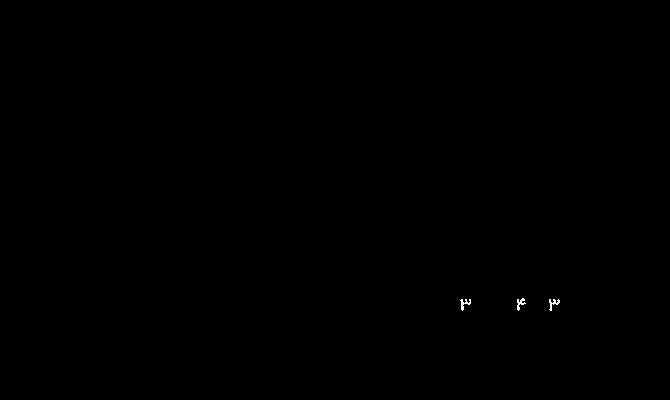

In [97]:
# Build an image without zero, slash and one
for i in range(labeledimg.shape[0]):
  for j in range(labeledimg.shape[1]):
    if labeledimg[i,j] in LabelsWithoutZeroSlashOne:
      labeledimg[i,j] = 255
    else:
      labeledimg[i,j] = 0
cv2_imshow(labeledimg)

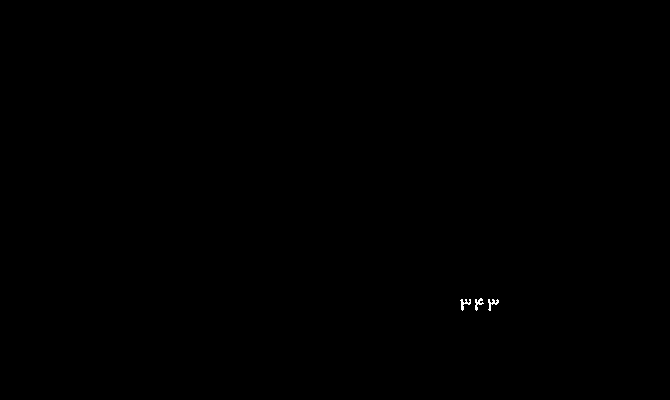

In [98]:
# Closing numbers to each other to create a single number for a better OCRing
newimg = ClosingNumbersTogether(labeledimg)
cv2_imshow(newimg)

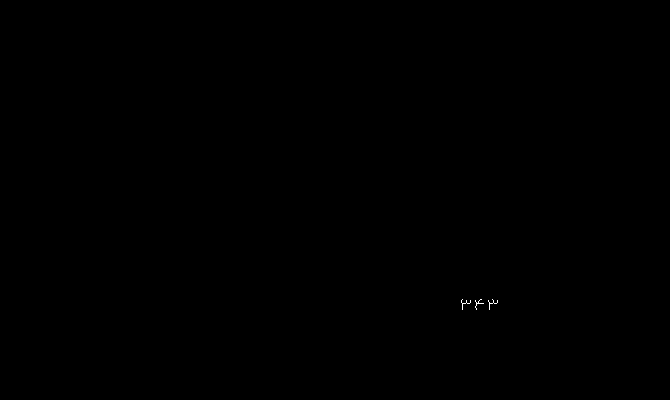

In [99]:
# Get the skeletone of our image
newimg = SkeletoneGrayImage(newimg)
cv2_imshow(newimg)

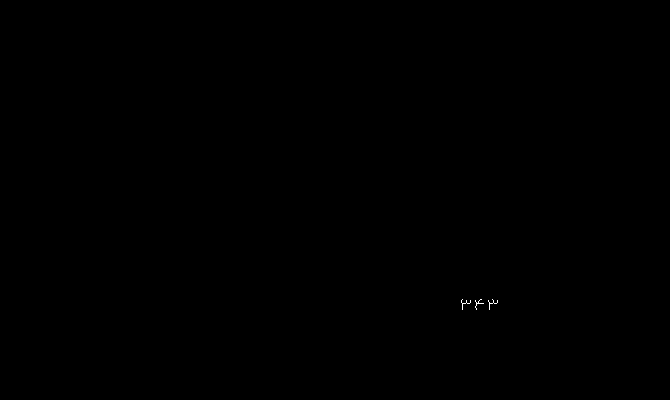

In [100]:
# Closing numbers to each other to create a single number for a better OCRing
newimg = ClosingNumbersTogether(newimg)
cv2_imshow(newimg)

In [101]:
Is, Js = [], []
for i in range(newimg.shape[0]):
  for j in range(newimg.shape[1]):
    if newimg[i,j] != 0:
      Is.append(i)
      Js.append(j)

finalimg = newimg[min(Is)-10:max(Is)+10, min(Js)-10:max(Js)+10]
cv2_imshow(finalimg)

In [102]:
for i in range(finalimg.shape[0]):
  for j in range(finalimg.shape[1]):
    if finalimg[i,j] != 0:
      finalimg[i,j-1] = 255

cv2_imshow(finalimg)

In [103]:
cv2.imwrite("expirydate.jpg", finalimg)

True

# TEST:

In [104]:
def ConvertIntToStr(mylist):
  strlist = str(int(mylist[0]))
  # if 11 in mylist:
  for i in range(len(mylist)-1):
    if mylist[i+1] == 11:
      strlist = strlist + '/'
    else:
      strlist = strlist + str(int(mylist[i+1]))
  return strlist

def ChangingTheOrderOfNumbers(outputlist):
  # If there is a space in the output, we should change the order of numbers. Because of persian language.
  mylistnumbers = []
  partnumbers = []

  if ' ' in outputlist:
    for i in range(len(outputlist)):
      reverseI = len(outputlist)-(i+1)
      if outputlist[reverseI] == ' ':
        if (reverseI == 0) or (reverseI == len(outputlist)-1): # IF WE ARE AT THE START OR END OF THE LIST
          pass
        else:
          partnumbers.reverse()
          for number in partnumbers:
            mylistnumbers.append(number)
          partnumbers = []

      else:
        partnumbers.append(outputlist[reverseI])

      if (reverseI == 0) and (partnumbers): # APPEND THE LAST PART WHICH HAS'NT APPENDED
        partnumbers.reverse()
        for number in partnumbers:
          mylistnumbers.append(number)
  else:
    mylistnumbers = outputlist

  return mylistnumbers

## BirthDate:

In [105]:
image_path='birthdate.jpg'
out_image='Output/birthdateout.jpg'
resultsbirthdate=arabicocr.arabic_ocr(image_path,out_image)
print(resultsbirthdate)

[INFO] OCR'ing input image...
[INFO] 0.9950: ٣٥٤٩
[[[[7, 9], [57, 9], [57, 25], [7, 25]], '٣٥٤٩', 0.9949515517704228]]


In [106]:
 listnumbers = ChangingTheOrderOfNumbers(list(resultsbirthdate[0][1]))
 print(listnumbers)

['٣', '٥', '٤', '٩']


In [107]:
BirthDate = BDList.copy()

In [108]:
# Placing numbers to the final list
j = 0
for i in range(len(BirthDate)):
  if BirthDate[i] == 0:
    try:
      BirthDate[i] = listnumbers[j]
      j = j+1
    except:
      j = j+1
      pass
try:
  BirthDate[BirthDate==10] = 0
except:
  pass
  
print(BirthDate)

[ 1.  3.  5.  4. 11.  0.  9. 11.  1.  1.]


In [109]:
BirthDate = ConvertIntToStr(BirthDate)
print(BirthDate)

1354/09/11


## ExpiryDate:

In [110]:
image_path='expirydate.jpg'
out_image='Output/expirydateout.jpg'
resultsexpirydate=arabicocr.arabic_ocr(image_path,out_image)
print(resultsexpirydate)

[INFO] OCR'ing input image...
[INFO] 0.5103: ٣٤٣
[[[[7, 9], [49, 9], [49, 25], [7, 25]], '٣٤٣', 0.5102979445503414]]


In [111]:
 listnumbers = ChangingTheOrderOfNumbers(list(resultsexpirydate[0][1]))
 print(listnumbers)

['٣', '٤', '٣']


In [112]:
ExpiryDate = EDList.copy()

In [113]:
# Placing numbers to the final list
j = 0
for i in range(len(ExpiryDate)):
  if ExpiryDate[i] == 0:
    try:
      ExpiryDate[i] = listnumbers[j]
      j = j+1
    except:
      j = j+1
      pass
try:
  ExpiryDate[ExpiryDate==10] = 0
except:
  pass
print(ExpiryDate)

[ 1.  3.  0.  0. 11.  0.  4. 11.  1.  3.]


In [114]:
ExpiryDate = ConvertIntToStr(ExpiryDate)
print(ExpiryDate)

1300/04/13


## IDNmber:

In [115]:
image_path='idnumber.jpg'
out_image='Output/idnumberout.jpg'
resultsidnumber=arabicocr.arabic_ocr(image_path,out_image)
print(resultsidnumber)

[INFO] OCR'ing input image...
[INFO] 0.4873: ٢٣٤٥٦٧٨
[[[[5, 5], [91, 5], [91, 25], [5, 25]], '٢٣٤٥٦٧٨', 0.4873444981516883]]


In [116]:
 listnumbers = ChangingTheOrderOfNumbers(list(resultsidnumber[0][1]))
 print(listnumbers)

['٢', '٣', '٤', '٥', '٦', '٧', '٨']


In [117]:
IDNumber = IDList.copy()

In [118]:
# Placing numbers to the final list
j = 0
for i in range(len(IDNumber)):
  if IDNumber[i] == 0:
    try:
      IDNumber[i] = listnumbers[j]
      j = j+1
    except:
      j = j+1
      pass

IDNumber[IDNumber==10] = 0
print(IDNumber)

[1. 2. 3. 4. 5. 6. 7. 8.]


In [119]:
IDNumber = ConvertIntToStr(IDNumber)
print(IDNumber)

12345678


## FamilyName:

In [120]:
image_path='familyname.jpg'
out_image='Output/familynameout.jpg'
resultsfamilyname=arabicocr.arabic_ocr(image_path,out_image)

fullword = resultsfamilyname[0][1]
if len(resultsfamilyname) != 1:
  for i in range(len(resultsfamilyname)-1):
    fullword = fullword + resultsfamilyname[i+1][1]
familynametext = fullword
print(familynametext)
familynamelistARABIC = list(familynametext)

[INFO] OCR'ing input image...
[INFO] 0.4586: مالحى
مالحى


In [121]:
imgpl = Image.fromarray(familyname)
text = pytesseract.image_to_string(imgpl, lang='fas')
print(list(text))

['م', 'ا', 'ل', 'ح', 'ی', '\n', '\x0c']


In [122]:
textlist = list(text)
try:
  textlist.remove('\n')
  textlist.remove('\x0c')
except:
  pass

In [123]:
if (len(textlist) == len(familynamelistARABIC)) and (('گ' in textlist) or ('چ' in textlist) or ('پ' in textlist) or ('ژ' in textlist)):
  FamilyNameList = textlist
elif len(textlist) > len(familynamelistARABIC)+1:
  FamilyNameList = textlist
else:
  FamilyNameList = familynamelistARABIC
print(FamilyNameList)

['م', 'ا', 'ل', 'ح', 'ى']


In [124]:
FamilyName = FamilyNameList[0]
for i in range(len(FamilyNameList)-1):
  FamilyName = FamilyName + FamilyNameList[i+1]
print(FamilyName)

مالحى


## FatherName:

In [125]:
image_path='fathername.jpg'
out_image='Output/fathernameout.jpg'
resultsfathername=arabicocr.arabic_ocr(image_path,out_image)

fullword = resultsfathername[0][1]
if len(resultsfathername) != 1:
  for i in range(len(resultsfathername)-1):
    fullword = fullword + resultsfathername[i+1][1]
fathernametext = fullword
print(fathernametext)
fathernamelistARABIC = list(fathernametext)

[INFO] OCR'ing input image...
[INFO] 0.2919: فقاسم
فقاسم


In [126]:
imgpl = Image.fromarray(fathername)
text = pytesseract.image_to_string(imgpl, lang='fas')
print(list(text))

['ق', 'ا', 'س', 'م', '\n', '\x0c']


In [127]:
textlist = list(text)
try:
  textlist.remove('\n')
  textlist.remove('\x0c')
except:
  pass

In [128]:
if (len(textlist) == len(fathernamelistARABIC)) and (('گ' in textlist) or ('چ' in textlist) or ('پ' in textlist) or ('ژ' in textlist)):
  FatherNameList = textlist
elif len(textlist) >= (len(fathernamelistARABIC)-1): # If it's a normal Persian name, Persian ocr can work better. So if recognized letters by Persian ocr is longer than the Arabic one, we pick the Persian result.
  FatherNameList = textlist
else:
  FatherNameList = fathernamelistARABIC
print(FatherNameList)

['ق', 'ا', 'س', 'م']


In [129]:
FatherName = FatherNameList[0]
for i in range(len(FatherNameList)-1):
  FatherName = FatherName + FatherNameList[i+1]
print(FatherName)

قاسم


## Name:

In [130]:
image_path='name.jpg'
out_image='Output/nameout.jpg'
resultsname=arabicocr.arabic_ocr(image_path,out_image)

fullword = resultsname[0][1]
if len(resultsname) != 1:
  for i in range(len(resultsname)-1):
    fullword = fullword + resultsname[i+1][1]
nametext = fullword
print(nametext)
namelistARABIC = list(nametext)

[INFO] OCR'ing input image...
[INFO] 0.8143: مسلم
مسلم


In [131]:
imgpl = Image.fromarray(name)
text = pytesseract.image_to_string(imgpl, lang='fas')
print(list(text))

['\x0c']


In [132]:
textlist = list(text)
try:
  textlist.remove('\n')
  textlist.remove('\x0c')
except:
  pass

In [133]:
if (len(textlist) == len(namelistARABIC)) and (('گ' in textlist) or ('چ' in textlist) or ('پ' in textlist) or ('ژ' in textlist)):
  NameList = textlist
elif len(textlist) > len(namelistARABIC)+1:
  NameList = textlist
else:
  NameList = namelistARABIC
print(NameList)

['م', 'س', 'ل', 'م']


In [134]:
Name = NameList[0]
for i in range(len(NameList)-1):
  Name = Name + NameList[i+1]
print(Name)

مسلم
